In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip

In [ ]:
pip install seaborn

In [1]:
from pyannote.core import Annotation, Segment
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import JaccardErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.database.util import load_rttm
import pandas as pd
import os

In [3]:
import seaborn as sns
import matplotlib.pyplot

In [4]:
#Инициализация классов-метрик
diarizationErrorRate = DiarizationErrorRate()
jaccardErrorRate = JaccardErrorRate()
purity = DiarizationPurity()

In [11]:
#Загрузка всех аннотаций 
def annotSet(RefRttm, HypoRttm):
    Ref = Annotation()
    Hypo = Annotation()

    Ref = RefRttm

    for speaker in HypoRttm.labels():
        Hypo = HypoRttm.rename_labels({speaker:speaker + "_Hypo"})

    return Ref, Hypo

#Маппинг аннотаций полученных rttm файлов на основе экспертных для вычисления метрик
def renameAnnotes(Ref, Hypo):
    Hypo = Hypo.rename_labels(mapping=diarizationErrorRate.optimal_mapping(Ref, Hypo))
    
    return Hypo

In [12]:
from pydub import AudioSegment

def annotSetF1(RefRttm, HypoRttm, wav_path):
    audio = AudioSegment.from_file(wav_path)
    eof = audio.duration_seconds
    
    Ref = Annotation()
    Hypo = Annotation()
    
    tempHypoRttm = Annotation()
    tempHypoRttm = HypoRttm.rename_labels(mapping=diarizationErrorRate.optimal_mapping(RefRttm, HypoRttm))
    
    Ref[Segment(0, eof)] = "Zero"
    Ref = Ref.extrude(RefRttm.get_timeline())
    for segment, speaker, label in RefRttm.itertracks(yield_label=True):
        Ref[segment] = label

    
    Hypo[Segment(0, eof)] = "Zero"
    Hypo = Hypo.extrude(tempHypoRttm.get_timeline())
    for segment, speaker, label in tempHypoRttm.itertracks(yield_label=True):
        Hypo[segment] = label


    return Ref, Hypo

In [17]:
#Подсчет метрик Accuracy, Precision, Recall, F1
def stats(ref, hypo, method, table):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0
    
    for speaker in ref.labels():
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
        trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
        falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
        falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
        
        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        #print('truePositive: ' + str(truePositive))
        #print('trueNegative: ' + str(trueNegative))
        #print('falsePositive: ' + str(falsePositive))
        #print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0

        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0
        #print(Recall)
        F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0

        table.loc[len(table)] = [method, speaker, round(Accuracy,2), round(Precision,2), round(Recall,2), round(F1,2)]
    
    global ggTP, ggTN, ggFP, ggFN
    
    global globalAccuracy, globalPrecision, globalRecall, globalF1
    
    ggTP += gTP
    ggTN += gTN
    ggFP += gFP
    ggFN += gFN
    
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP) if gFP+gTP != 0 else 0
    gRecall = gTP/(gFN+gTP) if gFN+gTP != 0 else 0
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision) if gRecall+gPrecision != 0 else 0
    table.loc[len(table)] = [method,"Общее",round(gAccuracy,2), round(gPrecision,2) ,round(gRecall,2), round(gF1,2) ]

    globalAccuracy += gAccuracy / count
    globalPrecision += gPrecision / count
    globalRecall += gRecall / count
    globalF1 += gF1 / count

#Выполнение подсчета метрик для всех данных
def st(Ref, Hypo, methodName, table):
    stats(Ref, Hypo, methodName, table)

#################################################################################################################


def DERstats(ref, hypo, name, table):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    DER = round(diarizationErrorRate(ref, hypo, detailed=True)['diarization error rate']*100,2)
    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    Alarm = round(diarizationErrorRate(ref, hypo, detailed=True)['false alarm'] * 100 / total,2)
    #print("Conf: " + str(Conf) + "\nDer: " + str(DER))
    
    global gConf, gMiss, gAlarm, gTime, count
    global globalAlarm, globalMiss, globalConf, globalDER
    
    gConf += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
    gMiss += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
    gAlarm += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
    gTime += diarizationErrorRate(ref, hypo, detailed=True)['total']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    
    table.loc[len(table)] = [ name, Alarm, Miss ,Conf, DER ]

    globalAlarm += Alarm/count
    globalMiss += Miss/count
    globalConf += Conf/count
    globalDER += DER/count

def stDer(Ref, Hypo, methodName, table):
    DERstats(Ref, Hypo, methodName, table)

#################################################################################################################

def JERstats(ref, hypo, name, table):
    speakers = jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    JER = round(jaccardErrorRate(ref, hypo, detailed=True)['jaccard error rate']*100, 2)
    speakerError = round(jaccardErrorRate(ref, hypo, detailed=True)['speaker error'] * 100, 2)
    
    global gSpeakers, gSpeakerError, count
    global globalJER
    
    gSpeakers += jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    gSpeakerError += jaccardErrorRate(ref, hypo, detailed=True)['speaker error']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    globalJER += JER / count
    table.loc[len(table)] = [ name, speakers, speakerError ,JER ]

def stJer(Ref, Hypo, methodName, table):
    JERstats(Ref, Hypo, methodName, table)

################################################################################################################

def calculateMetrics(methodName):
    ##########################################################################################################
    main_path = "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/"
    folder_path = main_path + "diarization/"
    RefRttm_path = "Reference/"
    HypoRttm_path = methodName + "/"
    research_path = main_path + "results/"
    
    # Получаем список имен файлов в папке
    RefFile_names = os.listdir(folder_path + RefRttm_path)
    HypoFile_names = os.listdir(folder_path + HypoRttm_path)
    
    # Сортируем имена файлов в алфавитном порядке
    sorted_RefFiles = sorted(RefFile_names)
    sorted_HypoFiles = sorted(HypoFile_names)
    
    RefRttm = []
    HypoRttm = []
    names = []
    global count
    count = 0

    for files in sorted(sorted_RefFiles):
        print(folder_path + RefRttm_path + files)
        RefRttm.append(load_rttm(folder_path + RefRttm_path + files).popitem()[1])
        names.append(os.path.splitext(os.path.basename(files))[0])
        count += 1
    for files in sorted(sorted_HypoFiles):
        HypoRttm.append(load_rttm(folder_path + HypoRttm_path + files).popitem()[1])
        
    Ref = []
    Hypo = []
    for j in range(count):
        RefTemp, HypoTemp = annotSet(RefRttm[j], HypoRttm[j])
        HypoTemp = renameAnnotes(RefTemp,HypoTemp)
        Ref.append(RefTemp)
        Hypo.append(HypoTemp)

    Ref2 = []
    Hypo2 = []
    for j in range(count):
        RefTemp, HypoTemp = annotSetF1(RefRttm[j], HypoRttm[j], "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/audio/default/"+ names[j] +".wav")
        Ref2.append(RefTemp)
        Hypo2.append(HypoTemp)
        
    ##########################################################################################################
    
    global tableF1, tableDER, tableJER, tableF1Avg, tableDERAvg, tableJERAvg
    
    global globalJER
    
    global ggTP, ggTN, ggFP, ggFN
    ggTP = 0
    ggTN = 0
    ggFP = 0
    ggFN = 0
    
    if not os.path.exists(research_path + methodName + "/"):
        os.mkdir(research_path + methodName + "/")

    print(1)
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_ResultsF1.xlsx', engine='xlsxwriter')
    table = pd.DataFrame(columns = ['Метод','Говорящий', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for j in range(count):
        st(Ref2[j], Hypo2[j], methodName, table)
    table.set_index(['Метод','Говорящий']).to_excel(writer, sheet_name="Рез")
    writer.close()
    
    print(2)
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_TotalF1.xlsx', engine='xlsxwriter')
    total = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    Accuracy = 0
    Precision = 0
    Recall = 0
    F1 = 0
    
    Accuracy = ((ggTP+ggTN)/(ggFP+ggFN+ggTP+ggTN))
    Precision = (ggTP/(ggFP+ggTP))
    Recall = (ggTP/(ggFN+ggTP))
    F1 = ((2*Recall*Precision)/(Recall+Precision))
    
    #Вывод средних метрик в зависимости от длительности
    total.loc[len(total)] = [methodName, round(Accuracy,2), round(Precision,2) ,round(Recall,2), round(F1,2) ]
    tableF1.loc[len(tableF1)] = [methodName, round(Accuracy,2), round(Precision,2) ,round(Recall,2), round(F1,2) ]
    total.to_excel(writer, 'total')
    writer.close()


    ##########################################################################################################
    
    global gConf, gMiss, gAlarm, gTime
    gConf = 0
    gMiss = 0
    gAlarm = 0
    gTime = 0
    
    print(3)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_DERResults.xlsx', engine='xlsxwriter')
    table = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
    for j in range (count):
        stDer(Ref[j], Hypo[j], methodName, table)
    table.to_excel(writer, sheet_name="Рез")
    writer.close()
    
    print(4)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_DerTotal.xlsx', engine='xlsxwriter')
    total = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
    
    falseAlarmPer = 0
    missPer = 0
    confPer = 0
    derPer = 0
    
    falseAlarmPer = gAlarm*100/gTime
    missPer = gMiss*100/gTime
    confPer = gConf*100/gTime
    derPer = (gAlarm + gMiss + gConf)*100/gTime
    
    total.loc[len(total)] = [methodName, round(falseAlarmPer,2), round(missPer,2), round(confPer,2), round(derPer,2) ]
    tableDER.loc[len(tableDER)] = [methodName, round(falseAlarmPer,2), round(missPer,2), round(confPer,2), round(derPer,2) ]
    
    #total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
    total.to_excel(writer, 'total')
    writer.close()


    ##########################################################################################################

    global gSpeakers, gSpeakerError
    gSpeakers = 0
    gSpeakerError = 0
    
    print(5)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_JERResults.xlsx', engine='xlsxwriter')
    table = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])
    for j in range (count):
        stJer(Ref[j], Hypo[j], methodName, table)
    table.to_excel(writer, sheet_name="Рез")
    writer.close()
    
    print(6)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_JerTotal.xlsx', engine='xlsxwriter')
    total = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

    jerPer = (gSpeakerError)*100/gSpeakers
    
    total.loc[len(total)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]
    tableJER.loc[len(tableJER)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]
    
    #total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
    total.to_excel(writer, 'total')
    writer.close()

In [19]:
allMethods = ["default","normalized","MTL","MTL_Normalized","MetricGAN","MetricGAN_Normalized",
              "deepFilterNet1","deepFilterNet1_normalized","deepFilterNet2","deepFilterNet2_normalized",
             "deepFilterNet3","deepFilterNet3_normalized"]

choosedMethods = ["default","normalized","MTL","MTL_Normalized"]

totalwriter = pd.ExcelWriter('C:/Users/sasha/OneDrive/Desktop/НИР/New Research/results/TotalDiar.xlsx', engine='xlsxwriter')
tableF1 = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
tableDER = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
tableJER = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

tableF1Avg = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
tableDERAvg = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
tableJERAvg = pd.DataFrame(columns = ['Метод', 'JER, %'])

global globalAccuracy, globalPrecision, globalRecall, globalF1, globalAlarm, globalMiss, globalConf, globalDER, globalJER, count

for method in allMethods:
    globalAccuracy = 0
    globalPrecision = 0
    globalRecall = 0
    globalF1 = 0
    
    globalAlarm = 0
    globalMiss = 0
    globalConf = 0
    globalDER = 0
    
    globalJER = 0
    
    ggTP = 0
    ggTN = 0
    ggFP = 0
    ggFN = 0
    
    gConf = 0
    gMiss = 0
    gAlarm = 0
    gTime = 0
    
    gSpeakers = 0
    gSpeakerError = 0
    
    calculateMetrics(method)
    tableF1Avg.loc[len(tableF1Avg)] = [method, round(globalAccuracy,2), round(globalPrecision,2), round(globalRecall,2), round(globalF1,2)]
    tableDERAvg.loc[len(tableDERAvg)] = [method, round(globalAlarm,2), round(globalMiss,2), round(globalConf,2), round(globalDER,2)]
    tableJERAvg.loc[len(tableJERAvg)] = [method, round(globalJER,2) ]

tableF1.to_excel(totalwriter, 'F1')
tableDER.to_excel(totalwriter, 'DER')
tableJER.to_excel(totalwriter, 'JER')

tableF1Avg.to_excel(totalwriter, 'F1Avg')
tableDERAvg.to_excel(totalwriter, 'DERAvg')
tableJERAvg.to_excel(totalwriter, 'JERAvg')

totalwriter.close()

C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha/O

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aepyx.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aggyz.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aiqwk.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/aorju.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/auzru.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bgvvt.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bidnq.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bjruf.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bmsyn.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bpzsc.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvqnu.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/diarization/Reference/bvyvm.rttm
C:/Users/sasha

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
3


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

4
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6


In [15]:
methodName = "normalized"
main_path = "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/"
folder_path = main_path + "diarization/"
RefRttm_path = "Reference/"
HypoRttm_path = methodName + "/"
research_path = main_path + "results/"

# Получаем список имен файлов в папке
RefFile_names = os.listdir(folder_path + RefRttm_path)
HypoFile_names = os.listdir(folder_path + HypoRttm_path)

# Сортируем имена файлов в алфавитном порядке
sorted_RefFiles = sorted(RefFile_names)
sorted_HypoFiles = sorted(HypoFile_names)

# Выводим отсортированные имена файлов
for files in sorted(sorted_RefFiles):
    print(files)
for files in sorted(sorted_HypoFiles):
    print(files)

abjxc.rttm
afjiv.rttm
akthc.rttm
ampme.rttm
atgpi.rttm
aufkn.rttm
azisu.rttm
bkwns.rttm
bwzyf.rttm
ccokr.rttm
cobal.rttm
cqaec.rttm
cwryz.rttm
cyyxp.rttm
djngn.rttm
dscgs.rttm
ehpau.rttm
eqttu.rttm
esrit.rttm
exymw.rttm
eziem.rttm
ezsgk.rttm
femmv.rttm
fsaal.rttm
fxgvy.rttm
ggvel.rttm
gpjne.rttm
gqbvk.rttm
gwtwd.rttm
gzvkx.rttm
hiyis.rttm
hqyok.rttm
ikgcq.rttm
imtug.rttm
iqtde.rttm
jhdav.rttm
jiqvr.rttm
jnivh.rttm
jsdmu.rttm
jsmbi.rttm
jyirt.rttm
kbkon.rttm
kctgl.rttm
kszpd.rttm
lknjp.rttm
luvfz.rttm
mesob.rttm
mevkw.rttm
migzj.rttm
mjgil.rttm
mpvoh.rttm
nctdh.rttm
ngyrk.rttm
nnqfq.rttm
nxgad.rttm
oekmc.rttm
oenox.rttm
plbbw.rttm
pqmho.rttm
qhesr.rttm
qjgpl.rttm
qppll.rttm
qpylu.rttm
qrzjk.rttm
qsfzo.rttm
qydmg.rttm
qzwxa.rttm
rcxzg.rttm
rtvuw.rttm
rxgun.rttm
sikkm.rttm
sldwj.rttm
spzmn.rttm
sqkup.rttm
syiwe.rttm
szsyz.rttm
tfvyr.rttm
tiams.rttm
tlprc.rttm
tucrg.rttm
uatlu.rttm
usbgm.rttm
uvnmy.rttm
vysqj.rttm
wdjyj.rttm
wewoz.rttm
whmpa.rttm
willh.rttm
wjhgf.rttm
wmori.rttm
xiglo.rttm

In [16]:
RefRttm = []
HypoRttm = []
i = 0
for files in sorted(sorted_RefFiles):
    RefRttm.append(load_rttm(folder_path + RefRttm_path + files).popitem()[1])
    i += 1
for files in sorted(sorted_HypoFiles):
    HypoRttm.append(load_rttm(folder_path + HypoRttm_path + files).popitem()[1])

In [17]:
Ref = []
Hypo = []
for j in range(i):
    RefTemp, HypoTemp = annotSet(RefRttm[j], HypoRttm[j])
    HypoTemp = renameAnnotes(RefTemp,HypoTemp)
    Ref.append(RefTemp)
    Hypo.append(HypoTemp)

In [26]:
#Подсчет метрик Accuracy, Precision, Recall, F1
def stats(ref, hypo, method, table):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    for speaker in ref.labels():
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
        trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
        falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
        falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
        
        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        #print('truePositive: ' + str(truePositive))
        #print('trueNegative: ' + str(trueNegative))
        #print('falsePositive: ' + str(falsePositive))
        #print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0

        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0
        #print(Recall)
        F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0

        table.loc[len(table)] = [method, speaker, round(Accuracy,5), round(Precision,5), round(Recall,5), round(F1,5)]
    
    global ggTP, ggTN, ggFP, ggFN
    
    ggTP += gTP
    ggTN += gTN
    ggFP += gFP
    ggFN += gFN
    
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP) if gFP+gTP != 0 else 0
    gRecall = gTP/(gFN+gTP) if gFN+gTP != 0 else 0
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision) if gRecall+gPrecision != 0 else 0
    table.loc[len(table)] = [method,"Общее",round(gAccuracy,5), round(gPrecision,5) ,round(gRecall,5), round(gF1,5) ]

#Выполнение подсчета метрик для всех данных
def st(Ref, Hypo, methodName, table):
    stats(Ref, Hypo, methodName, table)

In [27]:
ggTP = 0
ggTN = 0
ggFP = 0
ggFN = 0

if not os.path.exists(research_path + methodName + "/"):
    os.mkdir(research_path + methodName + "/")
    
writer = pd.ExcelWriter(research_path + methodName + '/ResultsF1.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод','Говорящий', 'Accuracy', 'Precision', 'Recall', 'F1'])
for j in range(i):
    st(Ref[j], Hypo[j], methodName, table)
table.set_index(['Метод','Говорящий']).to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/TotalF1.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])

Accuracy = 0
Precision = 0
Recall = 0
F1 = 0

Accuracy = ((ggTP+ggTN)/(ggFP+ggFN+ggTP+ggTN))
Precision = (ggTP/(ggFP+ggTP))
Recall = (ggTP/(ggFN+ggTP))
F1 = ((2*Recall*Precision)/(Recall+Precision))

#Вывод средних метрик в зависимости от длительности
total.loc[len(total)] = [methodName, round(Accuracy,5), round(Precision,5) ,round(Recall,5), round(F1,5) ]
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [28]:
def DERstats(ref, hypo, name, table):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    DER = round(diarizationErrorRate(ref, hypo, detailed=True)['diarization error rate']*100,2)
    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    Alarm = round(diarizationErrorRate(ref, hypo, detailed=True)['false alarm'] * 100 / total,2)
    #print("Conf: " + str(Conf) + "\nDer: " + str(DER))
    global gConf, gMiss, gAlarm, gTime

    gConf += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
    gMiss += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
    gAlarm += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
    gTime += diarizationErrorRate(ref, hypo, detailed=True)['total']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    
    table.loc[len(table)] = [ name, Alarm, Miss ,Conf, DER ]

def stDer(Ref, Hypo, methodName, table):
    DERstats(Ref, Hypo, methodName, table)

In [29]:
gConf = 0
gMiss = 0
gAlarm = 0
gTime = 0

writer = pd.ExcelWriter(research_path + methodName + '/DERResults.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
for j in range (i):
    stDer(Ref[j], Hypo[j], methodName, table)
table.to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/DerTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])

falseAlarmPer = 0
missPer = 0
confPer = 0
derPer = 0

falseAlarmPer = gAlarm*100/gTime
missPer = gMiss*100/gTime
confPer = gConf*100/gTime
derPer = (gAlarm + gMiss + gConf)*100/gTime
    
total.loc[len(total)] = [methodName, round(falseAlarmPer,2), round(missPer,2), round(confPer,2), round(derPer,2) ]

#total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [38]:
def JERstats(ref, hypo, name, table):
    speakers = jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    JER = round(jaccardErrorRate(ref, hypo, detailed=True)['jaccard error rate']*100, 2)
    speakerError = round(jaccardErrorRate(ref, hypo, detailed=True)['speaker error'] * 100, 2)
    
    global gSpeakers, gSpeakerError

    gSpeakers += jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    gSpeakerError += jaccardErrorRate(ref, hypo, detailed=True)['speaker error']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    
    table.loc[len(table)] = [ name, speakers, speakerError ,JER ]

def stJer(Ref, Hypo, methodName, table):
    JERstats(Ref, Hypo, methodName, table)

In [39]:
gSpeakers = 0
gSpeakerError = 0

writer = pd.ExcelWriter(research_path + methodName + '/JERResults.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])
for j in range (i):
    stJer(Ref[j], Hypo[j], methodName, table)
table.to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/JerTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

jerPer = (gSpeakerError)*100/gSpeakers
    
total.loc[len(total)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]

#total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [129]:
'''
#класс для представления диаризации
class Turn(object):
    """Speaker turn class.
    A turn represents a segment of audio attributed to a single speaker.
    Parameters
    ----------
    onset : float
        Onset of turn in seconds from beginning of recording.
    offset : float, optional
        Offset of turn in seconds from beginning of recording. If None, then
        computed from ``onset`` and ``dur``.
        (Default: None)
    dur : float, optional
        Duration of turn in seconds. If None, then computed from ``onset`` and
        ``offset``.
        (Default: None)
    speaker_id : str, optional
        Speaker id.
        (Default: None)
    file_id : str, optional
        File id.
        (Default: none)
    """
    def __init__(self, onset, offset=None, dur=None, speaker_id=None,
                 file_id=None):
        if not (bool(offset is None) != bool(dur is None)):
            raise ValueError('Exactly one of offset or dur must be given')
        if onset < 0:
            raise ValueError('Turn onset must be >= 0 seconds')
        if offset:
            dur = offset - onset
        if dur <= 0:
            raise ValueError('Turn duration must be > 0 seconds')
        if not offset:
            offset = onset + dur
        self.onset = onset
        self.offset = offset
        self.dur = dur
        self.speaker_id = speaker_id
        self.file_id = file_id

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.__dict__ == other.__dict__
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash((self.onset, self.offset, self.dur, self.file_id,
                     self.speaker_id))

    def __str__(self):
        return ('FILE: %s, SPEAKER: %s, ONSET: %f, OFFSET: %f, DUR: %f' %
                (self.file_id, self.speaker_id, self.onset, self.offset,
                 self.dur))

    def __repr__(self):
        speaker_id = ("'%s'" % self.speaker_id if self.speaker_id is not None
                      else None)
        file_id = ("'%s'" % self.file_id if self.file_id is not None
                   else None)
        return ('Turn(%f, %f, None, %s, %s)' %
                (self.onset, self.offset, speaker_id, file_id))

#Спарсить данные rttm файла
def _parse_rttm_line(line):
    line = line.decode('utf-8').strip()
    fields = line.split()
    if len(fields) < 9:
        raise IOError('Number of fields < 9. LINE: "%s"' % line)
    file_id = fields[1]
    speaker_id = fields[7]

    # Check valid turn onset.
    try:
        onset = float(fields[3])
    except ValueError:
        raise IOError('Turn onset not FLOAT. LINE: "%s"' % line)
    if onset < 0:
        raise IOError('Turn onset < 0 seconds. LINE: "%s"' % line)

    # Check valid turn duration.
    try:
        dur = float(fields[4])
    except ValueError:
        raise IOError('Turn duration not FLOAT. LINE: "%s"' % line)
    if dur <= 0:
        raise IOError('Turn duration <= 0 seconds. LINE: "%s"' % line)

    return Turn(onset, dur=dur, speaker_id=speaker_id, file_id=file_id)

#Загрузить данные rttm файла
def load_rttm(rttmf):
  with open(rttmf, 'rb') as f:
      turns = []
      speaker_ids = set()
      file_ids = set()
      for line in f:
          if line.startswith(b'SPKR-INFO'):
              continue
          turn = _parse_rttm_line(line)
          turns.append(turn)
          speaker_ids.add(turn.speaker_id)
          file_ids.add(turn.file_id)
  return turns, speaker_ids, file_ids
'''

#Загрузка всех аннотаций 
def annotSet(RefRttm, PureRttm, MTLRttm, MetricGANRttm, MetricGAN_MTLRttm, MTL_MetricGANRttm):
    Ref = Annotation()
    Pure = Annotation()
    MTL = Annotation()
    MetricGAN = Annotation()
    MetricGAN_MTL = Annotation()
    MTL_MetricGAN = Annotation()

    Ref = RefRttm

    for speaker in PureRttm.labels():
        Pure = PureRttm.rename_labels({speaker:speaker + "_Hypo"})

    for speaker in MTLRttm.labels():
        MTL = MTLRttm.rename_labels({speaker:speaker + "_Hypo"})

    for speaker in MetricGANRttm.labels():
        MetricGAN = MetricGANRttm.rename_labels({speaker:speaker + "_Hypo"})

    for speaker in MetricGAN_MTLRttm.labels():
        MetricGAN_MTL = MetricGAN_MTLRttm.rename_labels({speaker:speaker + "_Hypo"})

    for speaker in MTL_MetricGANRttm.labels():
        MTL_MetricGAN = MTL_MetricGANRttm.rename_labels({speaker:speaker + "_Hypo"})

    return [Ref, Pure, MTL, MetricGAN, MetricGAN_MTL, MTL_MetricGAN]

#Маппинг аннотаций полученных rttm файлов на основе экспертных для вычисления метрик
def renameAnnotes(anSet):

    anSet[1] = anSet[1].rename_labels(mapping=diarizationErrorRate.optimal_mapping(anSet[0], anSet[1]))
    anSet[2] = anSet[2].rename_labels(mapping=diarizationErrorRate.optimal_mapping(anSet[0], anSet[2]))
    anSet[3] = anSet[3].rename_labels(mapping=diarizationErrorRate.optimal_mapping(anSet[0], anSet[3]))
    anSet[4] = anSet[4].rename_labels(mapping=diarizationErrorRate.optimal_mapping(anSet[0], anSet[4]))
    anSet[5] = anSet[5].rename_labels(mapping=diarizationErrorRate.optimal_mapping(anSet[0], anSet[5]))

    return anSet

'\n#класс для представления диаризации\nclass Turn(object):\n    """Speaker turn class.\n    A turn represents a segment of audio attributed to a single speaker.\n    Parameters\n    ----------\n    onset : float\n        Onset of turn in seconds from beginning of recording.\n    offset : float, optional\n        Offset of turn in seconds from beginning of recording. If None, then\n        computed from ``onset`` and ``dur``.\n        (Default: None)\n    dur : float, optional\n        Duration of turn in seconds. If None, then computed from ``onset`` and\n        ``offset``.\n        (Default: None)\n    speaker_id : str, optional\n        Speaker id.\n        (Default: None)\n    file_id : str, optional\n        File id.\n        (Default: none)\n    """\n    def __init__(self, onset, offset=None, dur=None, speaker_id=None,\n                 file_id=None):\n        if not (bool(offset is None) != bool(dur is None)):\n            raise ValueError(\'Exactly one of offset or dur must be

In [130]:
import os

folder_path = "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/"
rttm_path = "100 rttm/"
# Получаем список имен файлов в папке
file_names = os.listdir(folder_path + rttm_path)

# Сортируем имена файлов в алфавитном порядке
sorted_file_names = sorted(file_names)

# Выводим отсортированные имена файлов
for file_name in sorted_file_names:
    print(file_name)

abjxc.rttm
abjxcMTL.rttm
abjxcMTL_MetricGAN.rttm
abjxcMetricGAN.rttm
abjxcMetricGAN_MTL.rttm
abjxcPure.rttm
afjiv.rttm
afjivMTL.rttm
afjivMTL_MetricGAN.rttm
afjivMetricGAN.rttm
afjivMetricGAN_MTL.rttm
afjivPure.rttm
akthc.rttm
akthcMTL.rttm
akthcMTL_MetricGAN.rttm
akthcMetricGAN.rttm
akthcMetricGAN_MTL.rttm
akthcPure.rttm
ampme.rttm
ampmeMTL.rttm
ampmeMTL_MetricGAN.rttm
ampmeMetricGAN.rttm
ampmeMetricGAN_MTL.rttm
ampmePure.rttm
atgpi.rttm
atgpiMTL.rttm
atgpiMTL_MetricGAN.rttm
atgpiMetricGAN.rttm
atgpiMetricGAN_MTL.rttm
atgpiPure.rttm
aufkn.rttm
aufknMTL.rttm
aufknMTL_MetricGAN.rttm
aufknMetricGAN.rttm
aufknMetricGAN_MTL.rttm
aufknPure.rttm
azisu.rttm
azisuMTL.rttm
azisuMTL_MetricGAN.rttm
azisuMetricGAN.rttm
azisuMetricGAN_MTL.rttm
azisuPure.rttm
bkwns.rttm
bkwnsMTL.rttm
bkwnsMTL_MetricGAN.rttm
bkwnsMetricGAN.rttm
bkwnsMetricGAN_MTL.rttm
bkwnsPure.rttm
bwzyf.rttm
bwzyfMTL.rttm
bwzyfMTL_MetricGAN.rttm
bwzyfMetricGAN.rttm
bwzyfMetricGAN_MTL.rttm
bwzyfPure.rttm
ccokr.rttm
ccokrMTL.rttm
cco

In [161]:
i = 0
MTL_MetricGANRttm = []
MetricGAN_MTLRttm = []
MetricGANRttm = []
MTLRttm = []
PureRttm = []
RefRttm = []
for file_name in sorted_file_names:
    if file_name.endswith('MTL_MetricGAN.rttm'):
        MTL_MetricGANRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    elif file_name.endswith('MetricGAN_MTL.rttm'):
        MetricGAN_MTLRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    elif file_name.endswith('MetricGAN.rttm'):
        MetricGANRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    elif file_name.endswith('MTL.rttm'):
        MTLRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    elif file_name.endswith('Pure.rttm'):
        PureRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    else:
        RefRttm.append(load_rttm(folder_path + rttm_path + file_name).popitem()[1])
        
    i += 1
print("Суммарное количество считанных rttm файлов: " + str(i))

Суммарное количество считанных rttm файлов: 600


In [132]:
#Загрузка аннотаций от всех rttm файлов
Annotes = []
for j in range(i // 6):
    Annotes.append(annotSet(RefRttm[j], PureRttm[j], MTLRttm[j], MetricGANRttm[j], MetricGAN_MTLRttm[j], MTL_MetricGANRttm[j]))

In [133]:
for j in range(i // 6):
    Annotes[j] = renameAnnotes(Annotes[j])

In [142]:
ggTP = [0,0,0,0,0]
ggTN = [0,0,0,0,0]
ggFP = [0,0,0,0,0]
ggFN = [0,0,0,0,0]

In [143]:
#Подсчет метрик Accuracy, Precision, Recall, F1
def stats(ref, hypo, method, table):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    for speaker in ref.labels():
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
        trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
        falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
        falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
        
        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        #print('truePositive: ' + str(truePositive))
        #print('trueNegative: ' + str(trueNegative))
        #print('falsePositive: ' + str(falsePositive))
        #print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0

        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0
        #print(Recall)
        F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0

        table.loc[len(table)] = [method, speaker, round(Accuracy,5), round(Precision,5), round(Recall,5), round(F1,5)]
    
    global ggTP, ggTN, ggFP, ggFN
    
    if method == 'Pure':
        ggTP[0] += gTP
        ggTN[0] += gTN
        ggFP[0] += gFP
        ggFN[0] += gFN
    if method == 'MTL':
        ggTP[1] += gTP
        ggTN[1] += gTN
        ggFP[1] += gFP
        ggFN[1] += gFN
    if method == 'MetricGAN':
        ggTP[2] += gTP
        ggTN[2] += gTN
        ggFP[2] += gFP
        ggFN[2] += gFN
    if method == 'MTL_MetricGAN':
        ggTP[3] += gTP
        ggTN[3] += gTN
        ggFP[3] += gFP
        ggFN[3] += gFN
    if method == 'MetricGAN_MTL':
        ggTP[4] += gTP
        ggTN[4] += gTN
        ggFP[4] += gFP
        ggFN[4] += gFN
    
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP) if gFP+gTP != 0 else 0
    gRecall = gTP/(gFN+gTP) if gFN+gTP != 0 else 0
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision) if gRecall+gPrecision != 0 else 0
    table.loc[len(table)] = [method,"Общее",round(gAccuracy,5), round(gPrecision,5) ,round(gRecall,5), round(gF1,5) ]

#Выполнение подсчета метрик для всех данных
def st(anSet, index, table):
    stats(anSet[0], anSet[1], 'Pure', table)
    stats(anSet[0], anSet[2], 'MTL', table)
    stats(anSet[0], anSet[3], 'MetricGAN', table)
    stats(anSet[0], anSet[4], 'MTL_MetricGAN', table)
    stats(anSet[0], anSet[5], 'MetricGAN_MTL', table)

In [145]:
writer = pd.ExcelWriter('Results.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод','Говорящий', 'Accuracy', 'Precision', 'Recall', 'F1'])
for j in range(i//6):
    st(Annotes[j],j, table)
table.set_index(['Метод','Говорящий']).to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter('Total.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])

Accuracy = []
Precision = []
Recall = []
F1 = []

for i in range(5):
    Accuracy.append((ggTP[i]+ggTN[i])/(ggFP[i]+ggFN[i]+ggTP[i]+ggTN[i]))
    Precision.append(ggTP[i]/(ggFP[i]+ggTP[i]))
    Recall.append(ggTP[i]/(ggFN[i]+ggTP[i]))
    F1.append((2*Recall[i]*Precision[i])/(Recall[i]+Precision[i]))

#Вывод средних метрик в зависимости от длительности
total.loc[len(total)] = ['Pure', round(Accuracy[0],5), round(Precision[0],5) ,round(Recall[0],5), round(F1[0],5) ] 
total.loc[len(total)] = ['MTL', round(Accuracy[1],5), round(Precision[1],5) ,round(Recall[1],5), round(F1[1],5) ] 
total.loc[len(total)] = ['MetricGAN', round(Accuracy[2],5), round(Precision[2],5) ,round(Recall[2],5), round(F1[2],5) ] 
total.loc[len(total)] = ['MTL_MetricGAN', round(Accuracy[3],5), round(Precision[3],5) ,round(Recall[3],5), round(F1[3],5) ] 
total.loc[len(total)] = ['MetricGAN_MTL', round(Accuracy[4],5), round(Precision[4],5) ,round(Recall[4],5), round(F1[4],5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [165]:
def DERstats(ref, hypo, name, table):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    DER = round(diarizationErrorRate(ref, hypo, detailed=True)['diarization error rate']*100,2)
    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    Alarm = round(diarizationErrorRate(ref, hypo, detailed=True)['false alarm'] * 100 / total,2)
    #print("Conf: " + str(Conf) + "\nDer: " + str(DER))
    global gConf, gMiss, gAlarm, gTime

    if name == 'Pure':
        gConf[0] += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
        gMiss[0] += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
        gAlarm[0] += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
        gTime[0] += diarizationErrorRate(ref, hypo, detailed=True)['total']
        #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    if name == 'MTL':
        gConf[1] += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
        gMiss[1] += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
        gAlarm[1] += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
        gTime[1] += diarizationErrorRate(ref, hypo, detailed=True)['total']
    if name == 'MetricGAN':
        gConf[2] += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
        gMiss[2] += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
        gAlarm[2] += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
        gTime[2] += diarizationErrorRate(ref, hypo, detailed=True)['total']
    if name == 'MTL_MetricGAN':
        gConf[3] += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
        gMiss[3] += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
        gAlarm[3] += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
        gTime[3] += diarizationErrorRate(ref, hypo, detailed=True)['total']
    if name == 'MetricGAN_MTL':
        gConf[4] += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
        gMiss[4] += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
        gAlarm[4] += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
        gTime[4] += diarizationErrorRate(ref, hypo, detailed=True)['total']
    
    table.loc[len(table)] = [ name, Alarm, Miss ,Conf, DER ]

def stDer(anSet, table):
    DERstats(anSet[0], anSet[1], 'Pure', table)
    DERstats(anSet[0], anSet[2], 'MTL', table)
    DERstats(anSet[0], anSet[3], 'MetricGAN', table)
    DERstats(anSet[0], anSet[4], 'MTL_MetricGAN', table)
    DERstats(anSet[0], anSet[5], 'MetricGAN_MTL', table)

In [152]:
gConf = [0,0,0,0,0]
gMiss = [0,0,0,0,0]
gAlarm = [0,0,0,0,0]
gTime = [0,0,0,0,0]

In [167]:
writer = pd.ExcelWriter('DERResults.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
for j in range (i//6):
    stDer(Annotes[j], table)
table.to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter('DerTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])

falseAlarmPer = [0,0,0,0,0]
missPer = [0,0,0,0,0]
confPer = [0,0,0,0,0]
derPer = [0,0,0,0,0]

for k in range (5):
    falseAlarmPer[k] = gAlarm[k]*100/gTime[k]
    missPer[k] = gMiss[k]*100/gTime[k]
    confPer[k] = gConf[k]*100/gTime[k]
    derPer[k] = (gAlarm[k] + gMiss[k] + gConf[k])*100/gTime[k]
    
total.loc[len(total)] = ['Pure', round(falseAlarmPer[0],2), round(missPer[0],2), round(confPer[0],2), round(derPer[0],2) ] 
total.loc[len(total)] = ['MTL', round(falseAlarmPer[1],2), round(missPer[1],2) ,round(confPer[1],2), round(derPer[1],2) ] 
total.loc[len(total)] = ['MetricGAN', round(falseAlarmPer[2],2), round(missPer[2],2) ,round(confPer[2],2), round(derPer[2],2) ]
total.loc[len(total)] = ['MTL_MetricGAN', round(falseAlarmPer[3],2), round(missPer[3],2) ,round(confPer[3],2), round(derPer[3],2) ] 
total.loc[len(total)] = ['MetricGAN_MTL', round(falseAlarmPer[4],2), round(missPer[4],2) ,round(confPer[4],2), round(derPer[4],2) ]

#total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [134]:
statsOldPrint(Annotes[77][0], Annotes[77][4])

spk00
truePositive: 0.0
trueNegative: 129.83899999999997
falsePositive: 0.0
falseNegative: 10.458999999999975
Accuracy: 0.9254515388672684
Precision: 0
Recall: 0.0
F1: 0
spk01
truePositive: 19.501
trueNegative: 119.27899999999995
falsePositive: 1.1779999999999964
falseNegative: 0.33999999999999986
Accuracy: 0.9891801736304152
Precision: 0.9430339958411916
Recall: 0.9828637669472305
F1: 0.9625370187561699
spk02
truePositive: 0.0
trueNegative: 139.32199999999995
falsePositive: 0.0
falseNegative: 0.9759999999999982
Accuracy: 0.9930433790930733
Precision: 0
Recall: 0.0
F1: 0
spk03
truePositive: 97.08799999999998
trueNegative: 32.31099999999999
falsePositive: 10.458999999999975
falseNegative: 0.4399999999999977
Accuracy: 0.922315357310867
Precision: 0.9027494955693791
Recall: 0.9954884751045854
F1: 0.9468535901499453
spk04
truePositive: 11.493999999999996
trueNegative: 128.22599999999994
falsePositive: 0.5779999999999994
falseNegative: 0.0
Accuracy: 0.9958801978645454
Precision: 0.952120609

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


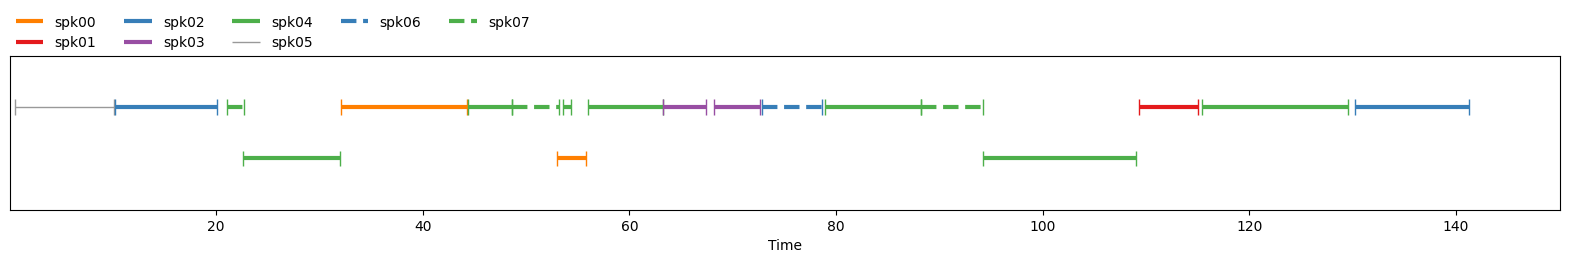

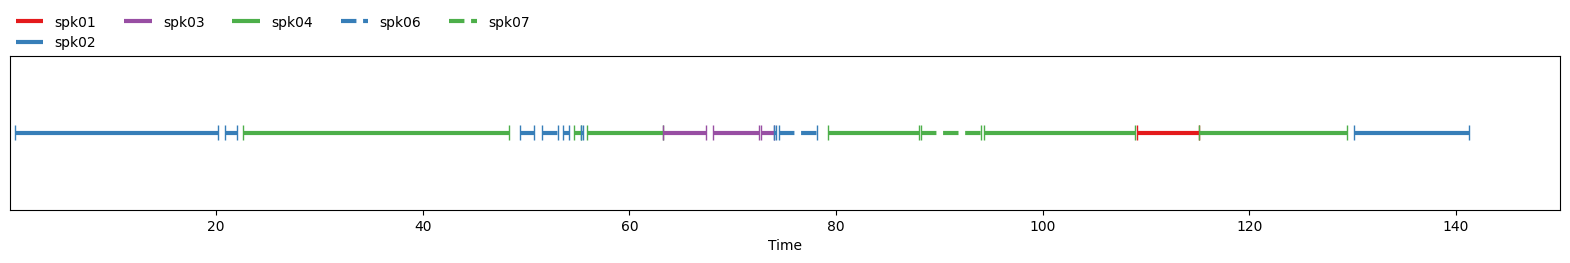

In [155]:
Annotes[78][0]
Annotes[78][4]

In [126]:
def statsOldPrint(ref, hypo):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    for speaker in ref.labels():
        print(speaker)
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
        trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
        falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
        falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
        
        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        print('truePositive: ' + str(truePositive))
        print('trueNegative: ' + str(trueNegative))
        print('falsePositive: ' + str(falsePositive))
        print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)
        print("Accuracy: " + str(Accuracy))
        
        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0
        print("Precision: " + str(Precision))
        
        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0
        print("Recall: " + str(Recall))
        
        F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0
        print("F1: " + str(F1))
    print()
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    print("Global Accuracy: " + str(gAccuracy))
    gPrecision = gTP/(gFP+gTP)
    print("Global Precision: " + str(gPrecision))
    gRecall = gTP/(gFN+gTP)
    print("Global Recall: " + str(gRecall))
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision)
    print("Global F1: " + str(gF1))

In [ ]:
def DERqstats(ref, hypo, name, table):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    DER = Conf + Miss
    
    global gConf, gMiss, gTime
    
    gConf += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
    gMiss += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
    gTime += diarizationErrorRate(ref, hypo, detailed=True)['total']
    
    table.loc[len(table)] = [ name, Miss ,Conf, DER ]

In [ ]:
def stDerq(anSet):
    table = pd.DataFrame(columns = ['Метод', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
    #DERqstats(anSet[0], anSet[1], 'Pure', table)
    #DERqstats(anSet[0], anSet[2], 'MTL', table)
    #DERqstats(anSet[0], anSet[3], 'MetricGAN', table)
    #DERqstats(anSet[0], anSet[4], 'MTL_MetricGAN', table)
    DERqstats(anSet[0], anSet[5], 'MetricGAN_MTL', table)
    table.to_excel(writer, sheet_name="Рез")
    writer.save()

In [ ]:
gConf = 0
gMiss = 0
gTime = 0

writer = pd.ExcelWriter('AnotherDialogDerqResults.xlsx', engine='xlsxwriter')
stDerq(AnotherDialogAnnotes)

writer = pd.ExcelWriter('DialogDerqResults.xlsx', engine='xlsxwriter')
stDerq(DialogAnnotes)

writer = pd.ExcelWriter('SpidermanDerqResults.xlsx', engine='xlsxwriter')
stDerq(SpidermanAnnotes)

writer = pd.ExcelWriter('ChikovDudDerqResults.xlsx', engine='xlsxwriter')
stDerq(ChikovDudAnnotes)

writer = pd.ExcelWriter('InterviewDerqResults.xlsx', engine='xlsxwriter')
stDerq(InterviewAnnotes)

writer = pd.ExcelWriter('DerqTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])

total.loc[len(total)] = [round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.save()

In [ ]:
def numOfActors(anSet):
    print("Кол-во акторов Ref: " + str(len(anSet[0].labels())))
    print("Кол-во акторов Pure: " + str(len(anSet[1].labels())))
    print("Кол-во акторов MTL: " + str(len(anSet[2].labels())))
    print("Кол-во акторов MetricGAN: " + str(len(anSet[3].labels())))
    print("Кол-во акторов MTL_MetricGAN: " + str(len(anSet[4].labels())))
    print("Кол-во акторов MetricGAN_MTL: " + str(len(anSet[5].labels())))

In [ ]:
print("Ref annotation:")
Annotes[79][0]
print("Pure annotation:")
Annotes[79][1]
print("MTL annotation:")
Annotes[79][2]
print("MetricGAN annotation:")
Annotes[79][3]
print("MetricGAN_MTL annotation:")
Annotes[79][4]
print("MTL_MetricGAN annotation:")
Annotes[79][5]

In [ ]:
numOfActors(DialogAnnotes)

numOfActors(AnotherDialogAnnotes)

numOfActors(SpidermanAnnotes)

numOfActors(ChikovDudAnnotes)

numOfActors(InterviewAnnotes)


In [ ]:
table = PrettyTable()
table.field_names = ["Name", "False alarm", "Missed detection", "Confusion", "DER"]

DERstats(table, Ref, Pure, "Pure")
DERstats(table, Ref, MTL, "MTL")
DERstats(table, Ref, MetricGAN, "MetricGAN")
DERstats(table, Ref, MTL_MetricGAN, "MTL + MetricGAN")
DERstats(table, Ref, MetricGAN_MTL, "MetricGAN + MTL")

print(table)

In [ ]:
def aDERstats(tbl, ref, hypo, name):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    DER = round(diarizationErrorRate(ref, hypo, detailed=True)['diarization error rate']*100,2)
    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    Alarm = round(diarizationErrorRate(ref, hypo, detailed=True)['false alarm'] * 100 / total,2)
    
    tbl.add_row([ name, Miss ,Conf, Miss + Conf])

In [ ]:
table = PrettyTable()
table.field_names = ["Name", "Missed detection", "Confusion", "DER"]

aDERstats(table, Ref, Pure, "Pure")
aDERstats(table, Ref, MTL, "MTL")
aDERstats(table, Ref, MetricGAN, "MetricGAN")

print(table)

In [ ]:
#Используется Венгерский алгоритм для оптимизации названий, чтобы в результате мы получили наиболее лучший результат.

#confusion:
#процент времени, когда в референсе один говорящий, а в гипотетическом другой.

#False alarm speech: 
#is the duration of non-speech incorrectly classified as speech

#Missed speech: 
#is the duration of speech incorrectly classified as non-speech

#total:
#общее время, на котором есть голос

#correct:
#общее время, на котором голос с гипотезы совпадает с референсом

In [ ]:
PureMatrix = Ref * Pure
MTLMatrix = Ref * MTL
MetricGANMatrix = Ref * MetricGAN
MetricGAN_MTLMatrix = Ref * MetricGAN_MTL
MTL_MetricGANMatrix = Ref * MTL_MetricGAN

In [ ]:
sns.heatmap(PureMatrix,cmap='coolwarm',annot=True, xticklabels = True)

In [ ]:
#Confusion matrix shows the association between the actual Vs predicted speakers’ labels
#as a function of speech duration (in seconds).

#How to look at this graph: 
#Ideally, matrices are squared (i.e., they have the same number of predicted/true values), 
#and so a perfect match between true and predicted speakers’ labels 
#is attested by a red-coloured diagonal line along the matrix. 

#Longer speech is not always associated to better prediction from the model.

#Ось у - референс, х - спрогнозированное
#Совпадающее
#Сверху вниз от совпадающего - false positive
#Слева направо от совпадающего - false negative
#Совпадающие - true positive
#сумма всего, что не принадлежит столбцу-строке нужного совпадающего - true negative

In [ ]:
def stats(matrix, num_of_speakers):
    table = PrettyTable()
    table.field_names = ["SPEAKER", "Accuracy", "Precision", "Recall", "F1"]
    
    
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    for num in range(num_of_speakers):
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        i = 0
        for row in matrix:
            j = 0
            for elem in row:
                if (i == num and j == num):
                    truePositive = elem
                if (i != num and j == num):
                    falsePositive += elem
                if (i == num and j != num):
                    falseNegative += elem
                if (i != num and j != num):
                    trueNegative += elem
                j += 1
            i += 1

        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        #print('truePositive: ' + str(truePositive))
        #print('trueNegative: ' + str(trueNegative))
        #print('falsePositive: ' + str(falsePositive))
        #print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0

        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0

        F1 = (2*Recall*Precision)/(Recall+Precision)

        table.add_row([num,round(Accuracy,4),round(Precision,4),round(Recall,4),round(F1,4)])
        

    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP)
    gRecall = gTP/(gFN+gTP)
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision)
    table.add_row(["",round(gAccuracy,4), round(gPrecision,4) ,round(gRecall,4), round(gF1,4) ])
    
    print(table)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
#
# Standardize the data set

#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(8, 6))
ax.matshow(PureMatrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(PureMatrix.shape[0]):
    for j in range(PureMatrix.shape[1]):
        ax.text(x=j, y=i, s=round(PureMatrix[i, j],1), va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
for speaker in Ref.labels():
    der_speaker = diarizationErrorRate(Ref.subset([speaker]), Pure.subset([speaker]), detailed=True)
    print(f"DER for {speaker}: {der_speaker}")